## Shelter Animal Outcomes
#### MIDS W207 Final Project
#### Clay Miller, Roseanna Hopper, Yubo Zhang

### Introduction

Approximately 6.5 to 7.6 million companion animals enter the animal shelters across the U.S. each year. Each year, approximately 1.5 million shelter animals are euthanized (670,000 dogs and 860,000 cats). The number of dogs and cats euthanized in U.S. shelters annually has declined from approximately 2.6 million in 2011. This decline can be partially explained by an increase in the percentage of animals adopted and an increase in the number of stray animals successfully returned to their owners.

For this exploration, we are using a dataset of intake information including breed, color, sex, and age from the [Austin Animal Center](https://www.kaggle.com/c/shelter-animal-outcomes), to develop a model that can be used for shelters to predict the outcome for each animal.  We are hoping that by using this model, the shelter can provide a little bit of extra help for animals that have a low adoption rate. In addition, we are hoping this dataset can help us to provide some key findings (for example, if age and gender would impact the adoption rate for dogs, if neutered or spayed cats are more likely to be adopted), understand which factors impact the chance of adoption, and identify differences between dog and cat adoption trends.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow 
import keras
import itertools

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn import tree

output_notebook()


%matplotlib inline

Loading BokehJS ...

### Raw Data

Each case in our raw training data is an individual animal, and the features include its characteristics (including name, animal type, age, gender, spay/neuter status, breed, coloring, and final outcome). Apart from age, all of the fields are categorical variables, so we’ll be creating binary variables for the majority of the fields (and their intersections). There are few missing values, and some cases where a field is marked as “Unknown” (appears in Name, Breed, and Gender). Overall, we are trying to predict the animal’s “final outcome”, of which there are five possibilities.


In [3]:
# Load the data
data = pd.read_csv('../data/train.csv')
breeds = pd.read_csv('../data/breeds.csv')
breeds['Breed'] = breeds['Breed'].str.strip()
top_breed_list = []
for b in breeds['Breed']:
    top_breed_list.append(b.strip())
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['Female'] = 'Female' in data['SexuponOutcome']
data['AgeuponOutcome'].fillna('', inplace = True)

#Create a continuous variable for age, making sure
#that all listed ages are on the same scale (months)
def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)


#Separate SexuponOutcome into Male/Female and into Intact/Spayed-Neutered
def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)

def top_breed(i):
    i = str(i)
    if any(word in i for word in top_breed_list):
        return int(1)
    else:
        return int(0)
data['TopBreed'] = data.Breed.apply(top_breed)

def breed_rank(i):
    i = str(i)
    ranks = []
    for word in top_breed_list:
        if word in i:
            ranks.append(int(breeds.loc[breeds['Breed'] == word]['2007']))
    if len(ranks) > 0:
        return np.mean(ranks)
    else:
        return 51.0
data['BreedRank'] = data.Breed.apply(breed_rank)

def pit_bull(i):
    i = str(i)
    if i.find("Pit Bull") >=0: return int(1)
    else: return int(0)
data['PitBull'] = data.Breed.apply(pit_bull)

def black_cat(i):
    i = str(i)
    if i == "Black": return int(1)
    else: return int(0)
data['BlackCat'] = data.Color.apply(black_cat)

def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

#Change all breed and color strings so that they are ordered consistently
#E.G. all "brown/black" and "black/brown" should become "black, brown"
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)


In [4]:
#Importing this because multiple deprecation warnings cluttering the output
import warnings
warnings.filterwarnings('ignore')

continuous = ['ConvertedAge', 'BreedRank']
discrete = [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'TopBreed',
    'PitBull',
    'BlackCat'
]
target = 'OutcomeType'

#For those missing an age, fill with the median age by animal type
data["ConvertedAge"] = data.groupby("AnimalType").transform(lambda x: x.fillna(x.median()))
data[continuous].describe().T

#Turn categorical variables into binaries
data2 = pd.concat([data[target], data[continuous], pd.get_dummies(data[discrete])], axis=1)

discrete = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed']


predictors = continuous + discrete
target = 'OutcomeType'


# Train/test split on the full dataset
X = data2[predictors]
y = data2[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=2)

#Normalize the continuous variables
ss = StandardScaler()
ss.fit(X_train[continuous])   # Compute mean and std of training data
X_train[continuous] = ss.transform(X_train[continuous])  # Use that mean and std to normalize columns of training data
X_dev[continuous] = ss.transform(X_dev[continuous]) 

In [5]:
#Define continuous and categorical variables

continuous = {'dog':['ConvertedAge', 'BreedRank'], 'cat':['ConvertedAge']}
discrete = {'dog':[
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'TopBreed',
    'PitBull'
], 'cat': [
    'AnimalType',
    'Female',
    'Intact',
    'MixedBreed',
    'Named',
    'BlackCat'
]}


pred = {'dog': continuous['dog'] + discrete['dog'], 'cat':continuous['cat']+discrete['cat']}
target = 'OutcomeType'

#For those missing an age, fill with the median age by animal type
data["ConvertedAge"] = data.groupby("AnimalType").transform(lambda x: x.fillna(x.median()))
print data[continuous['dog']].describe().T
print data[continuous['cat']].describe().T

                count        mean         std  min   25%   50%    75%     max
ConvertedAge  26729.0  113.370253  154.064766  0.0   9.0  52.0  156.0  1040.0
BreedRank     26729.0   35.975981   20.246237  1.0  12.0  51.0   51.0    51.0
                count        mean         std  min  25%   50%    75%     max
ConvertedAge  26729.0  113.370253  154.064766  0.0  9.0  52.0  156.0  1040.0


In [6]:
#Turn categorical variables into binaries, eliminating unconverted columns
data2_dog = pd.concat([data[target], data[continuous['dog']], pd.get_dummies(data[discrete['dog']])], axis=1)
data2_cat = pd.concat([data[target], data[continuous['cat']], pd.get_dummies(data[discrete['cat']])], axis=1)
print data2_dog.shape
print data2_cat.shape

(26729, 18)
(26729, 16)


In [7]:
#Split the data into cat and dog data sets
data2_dog = pd.concat([data[target], data[continuous['dog']], pd.get_dummies(data[discrete['dog']])], axis=1)
data2_cat = pd.concat([data[target], data[continuous['cat']], pd.get_dummies(data[discrete['cat']])], axis=1)

discrete_dog = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed', 'TopBreed', 'PitBull']

discrete_cat = ['AnimalType_Cat', 'AnimalType_Dog', 'Female_Female', 'Female_Male', 'Female_Unknown',
           'Intact_Intact', 'Intact_Spayed/Neutered', 'Intact_Unknown', 'MixedBreed_Known Breed Combo',
           'MixedBreed_Mixed Breed', 'MixedBreed_Nonmixed', 'Named_Named', 'Named_Unnamed', 'BlackCat']

predictors_dog = continuous['dog'] + discrete_dog
predictors_cat = continuous['cat'] + discrete_cat

# Train/test split
X_dog = data2_dog[data2_dog['AnimalType_Dog'] == 1][predictors_dog]
y_dog = data2_dog[data2_dog['AnimalType_Dog'] == 1][[target]]
X_dog_train, X_dog_dev, y_dog_train, y_dog_dev = train_test_split(X_dog, y_dog, random_state=2)

X_cat = data2_cat[data2_cat['AnimalType_Cat'] == 1][predictors_cat]
y_cat = data2_cat[data2_cat['AnimalType_Cat'] == 1][[target]]
X_cat_train, X_cat_dev, y_cat_train, y_cat_dev = train_test_split(X_cat, y_cat, random_state=2)

#Normalize 
ss_dog = StandardScaler()
ss_dog.fit(X_dog_train[continuous['dog']])   # Compute mean and std of training data
X_dog_train[continuous['dog']] = ss_dog.transform(X_dog_train[continuous['dog']])  # Use that mean and std to normalize columns of training data
X_dog_dev[continuous['dog']] = ss_dog.transform(X_dog_dev[continuous['dog']]) 
print X_dog.shape

ss_cat = StandardScaler()
ss_cat.fit(X_cat_train[continuous['cat']])   # Compute mean and std of training data
X_cat_train[continuous['cat']] = ss_cat.transform(X_cat_train[continuous['cat']])  # Use that mean and std to normalize columns of training data
X_cat_dev[continuous['cat']] = ss_cat.transform(X_cat_dev[continuous['cat']]) 
print X_cat.shape

(15595, 17)
(11134, 15)


### Exploratory Analysis

#### Visualizing Features

- We have approximately the same number of cats and dogs.
- The majority of animals are adopted or transferred; there are comparatively few cases of death or euthanasia.
- As we would expect, the majority of cases would be considered mixed breed. Also expected is that there are few animals beyond 15 years old.
- A large majority of animals are named (though whether by the shelter or a prior owner is unknown).

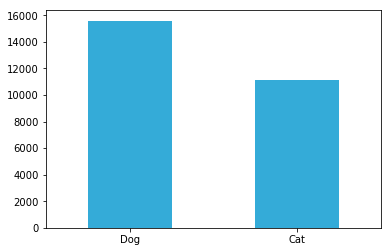

In [7]:
#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

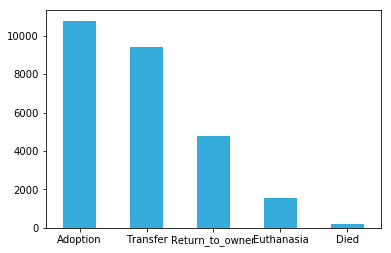

In [8]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

In [8]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

In [9]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

In [10]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E5FB160>]], dtype=object)

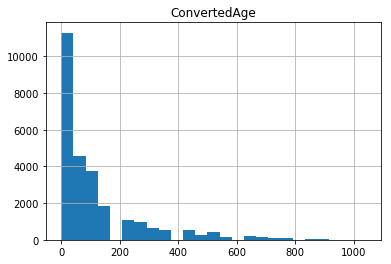

In [12]:
#Age of animals
data.hist(column="ConvertedAge", bins=25)

In [11]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [14]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())

('Unique Breeds', 1143)


### Correlations

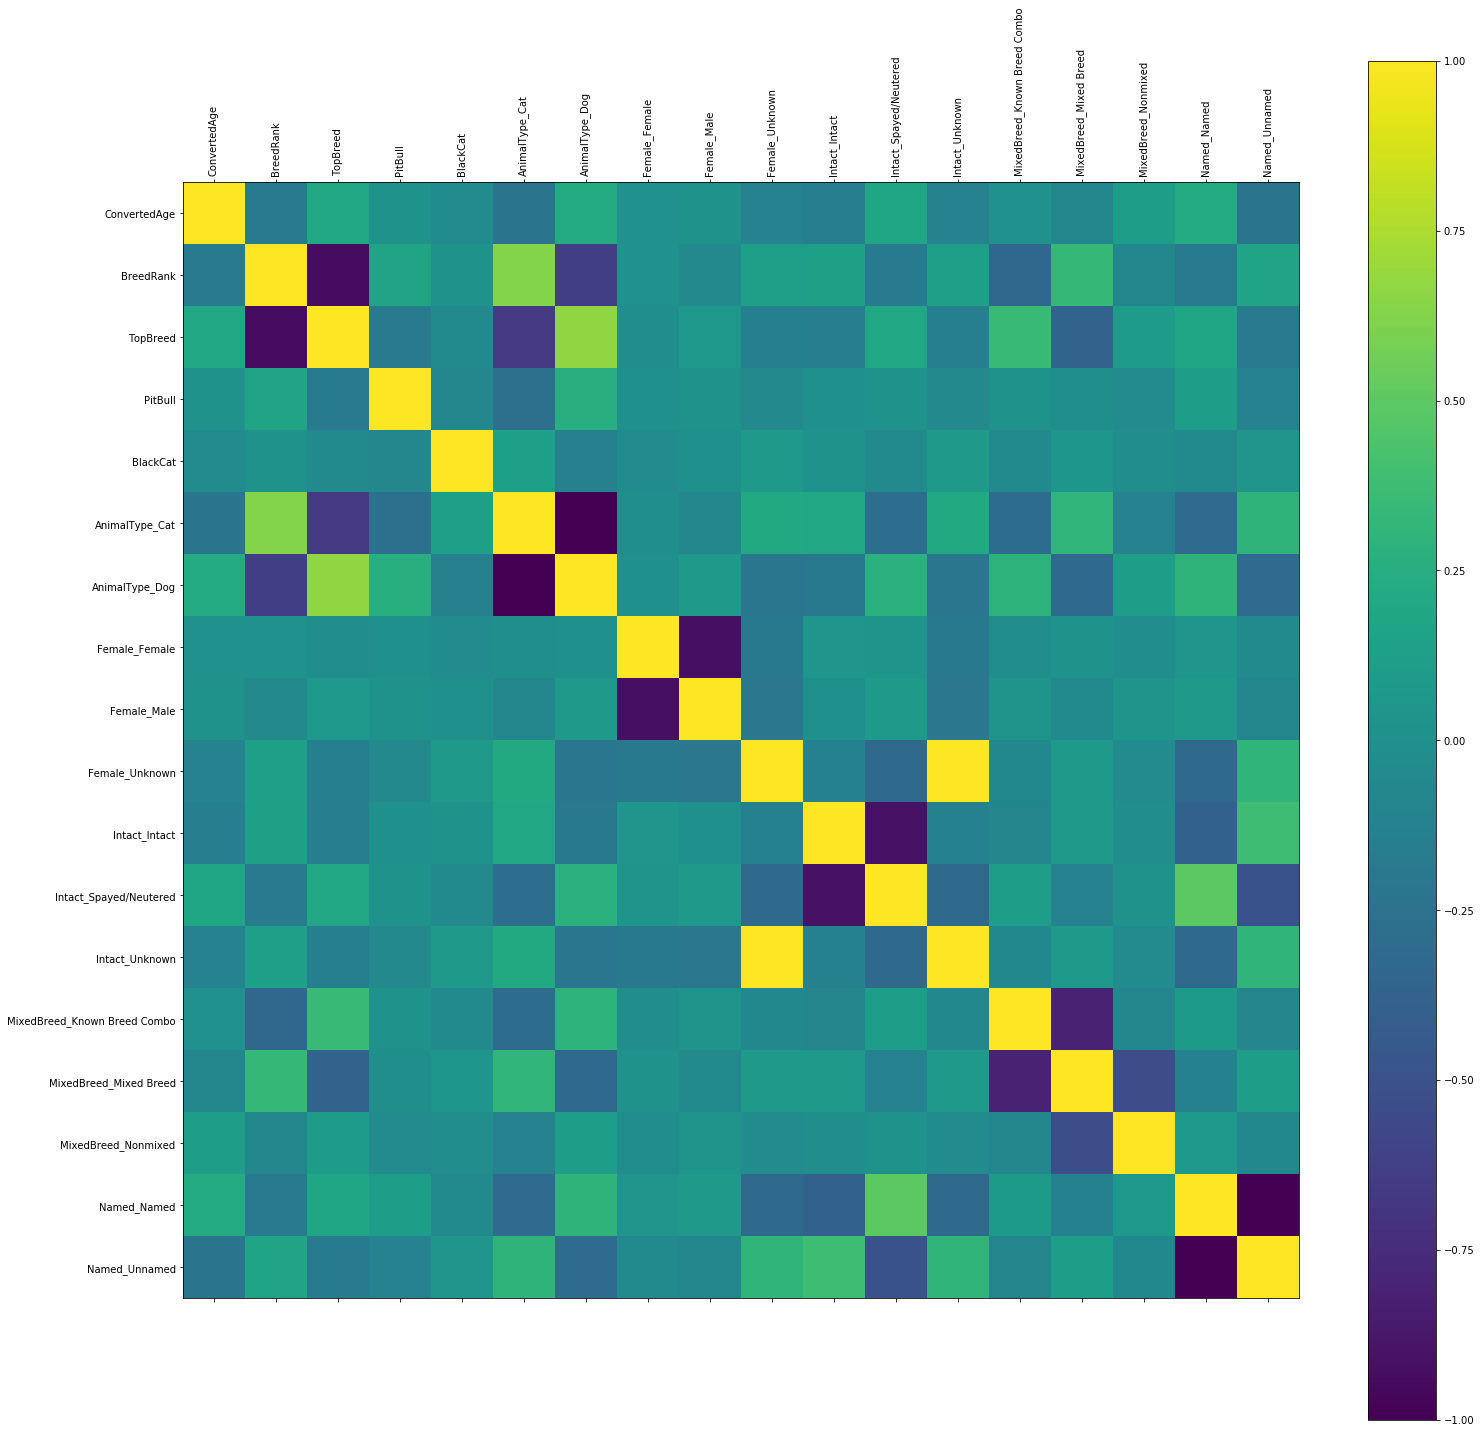

In [15]:
#Plot visualized correlation matrix
def plot_corr(data,size=20):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(25, 25))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.show()
plot_corr(data2)

Some of the most interesting findings here:  
- As we would expect, being spayed/neutered is moderately correlated with being named.
- There is a weak positive correlation between being spayed/neutered and being a cat.
- Between variables that aren't obviously or artificially related (like being a dog and being a pitbull), there are few relationships that could be characterized as more than moderately correlated.

#### Should dogs and cats be modeled separately?

- It appears that although cats and dogs in this dataset are adopted or transferred at similar rates, dogs have a much higher rate of returning to owner, so it may be advisable to separate the models by animal type.

In [12]:
#Animal types
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

## Modeling


### Logistic Regression Exploration

- With more than 26,000 cases, we have a more than adequate sample size for modeling.
- By their nature, the classes within the dependent variable (OutcomeType) should be independent of one another.
- Based on our correlation matrix, we should have no significant issues with multicollinearity.

#### Check Animal Type

We'll start by checking how dogs and cats perform in separate models, also using GridSearch to determine the best regularization strength.

In [13]:
#Find the best regularization strength
      #Generate logistic regression
def logit_reg(X_train, X_dev, y_train, y_dev, predict_anim):
    logit_reg = LogisticRegression(penalty="l2", multi_class='multinomial', solver='newton-cg')  
    print X_train.shape
    print type(pd.Series(y_train))
    y_train = y_train.values.ravel()
    y_dev = y_dev.values.ravel()
    
    #Test C within [0.001, 10]
    param_domain = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]
    param_dict = dict(C = param_domain)
    print param_dict

    #Initialize GridSearchCV to identify the optimal parameter values
    gridsearch = GridSearchCV(logit_reg, param_dict)
    gridsearch.fit(X_train, y_train)

    #Generate model at the best C value
    C = gridsearch.best_params_["C"]
    print "Train data: Logistic Regression score at C=%.3f: %f" % (C, gridsearch.best_score_)
    print ('\n' * 1)
    logit_reg = LogisticRegression(C=C, penalty="l2")
    logit_reg.fit(X_train, y_train)

    #Predict on the X_dev set
    logit_reg_dev = logit_reg.predict(X_dev)

    #Generate classification report
    print "Classification Report:"
    print " "
    print classification_report(y_dev, logit_reg_dev, target_names=logit_reg.classes_)
    print "Dev data: Logistic Regression score at C=%.3f: %f" % (C, metrics.f1_score(y_dev, logit_reg_dev, average="weighted"))    
    print "Weights:"
    #Get the variables with the highest weights for each outcome
    print logit_reg.classes_
    weights = []
    for i in range(len(logit_reg.classes_)):
        top_vars = np.argsort(logit_reg.coef_[i])[-6:-1]
        print logit_reg.classes_[i]
        for j in top_vars:
            print predict_anim[j], round(logit_reg.coef_[i][j],3)
        print
    print ('\n' * 2)


    #Generate logistic regression and add the squared weight values to an array, at each C
    logit_reg_coeff = []
    for c in param_domain:
        logit_reg = LogisticRegression(C=c, penalty="l2") 
        logit_reg.fit(X_train, y_train)
        squared_weights = []
        squared_weights.append(c)                       
        for i in range(0, 4):
            [squared_weights.append(np.sum(np.power(logit_reg.coef_[i], 2)))]
        logit_reg_coeff.append(squared_weights)

    coeff = np.asarray(logit_reg_coeff, dtype = "object")

print 'Logistic Regression: Dogs Only'
logit_reg(X_dog_train, X_dog_dev, y_dog_train, y_dog_dev, predictors_dog)
print 'Logistic Regression: Cats Only'
logit_reg(X_cat_train, X_cat_dev, y_cat_train, y_cat_dev, predictors_cat)

Logistic Regression: Dogs Only
(11696, 17)
<class 'pandas.core.series.Series'>
{'C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]}
Train data: Logistic Regression score at C=0.250: 0.561560


Classification Report:
 
                 precision    recall  f1-score   support

       Adoption       0.57      0.88      0.69      1629
           Died       0.00      0.00      0.00         9
     Euthanasia       0.38      0.02      0.03       187
Return_to_owner       0.53      0.34      0.42      1086
       Transfer       0.62      0.41      0.50       988

    avg / total       0.56      0.57      0.53      3899

Dev data: Logistic Regression score at C=0.250: 0.532516
Weights:
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
Adoption
BreedRank -0.037
Female_Male -0.03
AnimalType_Cat 0.0
MixedBreed_Known Breed Combo 0.061
Female_Female 0.259

Died
Named_Unnamed -0.034
AnimalType_Cat 0.0
Female_Unknown 0.036
Intact_Unknown 0.036
Intact_Intact 0.04

With the highest training accuracy on the dog-only model at 0.56 and the highest accuracy for cats at 0.74, here we see further evidence that cats and dogs should be modeled separately.

The model weights also yield some interesting results; note that the factors we thought might be important and highly weighted are not. For instance, we assumed that the breed would have played a much larger role in the outcome. Also of note is that in the dog model, the variable AnimalType_Cat - that is, whether or not the animal is a cat - has a higher weight than some other factors. This is the dog data though, so this should be a meaningless column in terms of outcomes.

### Logistic Regression Pipeline

Here we'll define a pipeline to binarize the categorical variables, scale the continuous variables, and fit a logistic regression; we're creating different models for dogs and cats so we'll define separate pipelines.

In [20]:
#Reset train/test split with pred
data_dog = data[data['AnimalType'] == 'Dog']
data_cat = data[data['AnimalType'] == 'Cat']
X_dog = data_dog[pred['dog']]
X_cat = data_cat[pred['cat']]
y_dog = data_dog[[target]]
y_cat = data_cat[[target]]
X_dog_train, X_dog_dev, y_dog_train, y_dog_dev = train_test_split(X_dog, y_dog, random_state=2)
X_cat_train, X_cat_dev, y_cat_train, y_cat_dev = train_test_split(X_cat, y_cat, random_state=2)


In [21]:
class MyVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, cols, hashing=None):
        """
        args:
            cols: a list of column names of the categorical variables
            hashing: 
                If None, then vectorization is a simple one-hot-encoding.
                If an integer, then hashing is the number of features in the output.
        """
        self.cols = cols
        self.hashing = hashing
        
    def fit(self, X, y=None):

        data = X[self.cols]
        
        # Choose a vectorizer
        if self.hashing is None:
            self.myvec = DictVectorizer(sparse=False)
        else:
            self.myvec = FeatureHasher(n_features = self.hashing)
    
        self.myvec.fit(X[self.cols].to_dict(orient='records'))
        return self
            
    def transform(self, X):
            
        # Vectorize Input
        if self.hashing is None:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')),
                columns = self.myvec.feature_names_
            )
        else:
            return pd.DataFrame(
                self.myvec.transform(X[self.cols].to_dict(orient='records')).toarray()
            )

In [22]:
class MyScaler():

    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X[self.cols])
        return self
    
    def transform(self, X):
        return self.ss.transform(X[self.cols])

In [23]:
#Set the pipelines for categorical variables
discrete_pipe_dog = Pipeline(steps=[('Vectorizer', MyVectorizer(cols=discrete['dog'], hashing=None))])
discrete_pipe_cat = Pipeline(steps=[('Vectorizer', MyVectorizer(cols=discrete['cat'], hashing=None))])

#Set the pipelines for continuous variables
continuous_pipe_cat = Pipeline(steps=[('Scale', MyScaler(continuous['cat']))])
continuous_pipe_dog = Pipeline(steps=[('Scale', MyScaler(continuous['dog']))])

#Bring the discrete and continuous pipelines together for cats and dogs
union_dog = FeatureUnion([('Discrete', discrete_pipe_dog), ('Continuous', continuous_pipe_dog)])
union_cat = FeatureUnion([('Discrete', discrete_pipe_cat), ('Continuous', continuous_pipe_cat)])

In [24]:
#Full pipelines, using the best regularization strengths for the dog and cat models, respectively
pipeline_dog = Pipeline([('Preprocess', FeatureUnion([('Discrete', discrete_pipe_dog), ('Continuous', continuous_pipe_dog)])),
                      ('Predict', LogisticRegression(multi_class='multinomial', C=0.25, solver='newton-cg'))])
pipeline_cat = Pipeline([('Preprocess', FeatureUnion([('Discrete', discrete_pipe_cat), ('Continuous', continuous_pipe_cat)])),
                      ('Predict', LogisticRegression(multi_class='multinomial', C=0.10, solver='newton-cg'))])

#Fit the multinomial logistic regression for dogs and cats, respectively
test_dog_lr = pipeline_dog.fit(X_dog_train, y_dog_train)
test_cat_lr = pipeline_cat.fit(X_cat_train, y_cat_train)

print "Dogs: Multinomial Logistic Regression Train Accuracy :: ", metrics.accuracy_score(y_dog_train, test_dog_lr.predict(X_dog_train))
print "Dogs: Multinomial Logistic Regression Dev Accuracy :: ", metrics.accuracy_score(y_dog_dev, test_dog_lr.predict(X_dog_dev))
print
print "Cats: Multinomial Logistic Regression Train Accuracy :: ", metrics.accuracy_score(y_cat_train, test_cat_lr.predict(X_cat_train))
print "Cats: Multinomial Logistic Regression Dev Accuracy :: ", metrics.accuracy_score(y_cat_dev, test_cat_lr.predict(X_cat_dev))

Dogs: Multinomial Logistic Regression Train Accuracy ::  0.562670998632
Dogs: Multinomial Logistic Regression Dev Accuracy ::  0.577840471916

Cats: Multinomial Logistic Regression Train Accuracy ::  0.738323353293
Cats: Multinomial Logistic Regression Dev Accuracy ::  0.739942528736


Normalized confusion matrix
[[  3.76e-01   9.21e-04   5.23e-01   1.00e-01   0.00e+00]
 [  3.37e-01   5.88e-02   2.67e-01   3.37e-01   0.00e+00]
 [  1.02e-01   6.14e-04   8.80e-01   1.72e-02   0.00e+00]
 [  1.23e-01   8.10e-03   4.64e-01   4.05e-01   0.00e+00]
 [  1.11e-01   0.00e+00   2.22e-01   6.67e-01   0.00e+00]]
Normalized confusion matrix
[[ 0.07  0.04  0.84  0.06  0.  ]
 [ 0.03  0.13  0.08  0.76  0.  ]
 [ 0.01  0.    0.91  0.08  0.  ]
 [ 0.01  0.    0.21  0.78  0.  ]
 [ 0.    0.    0.12  0.88  0.  ]]


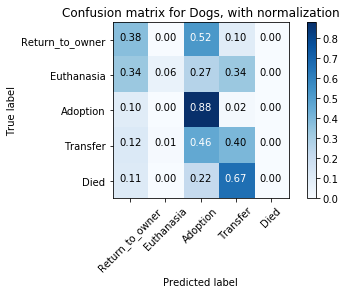

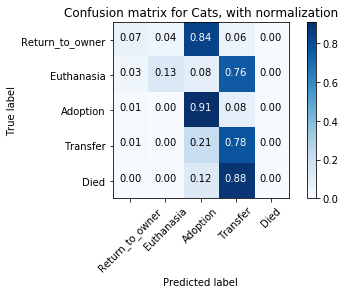

In [25]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']
cnf_dog_matrix = confusion_matrix(y_dog_dev, test_dog_lr.predict(X_dog_dev), labels = class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_dog_matrix, classes=class_names, normalize = True,
                      title='Confusion matrix for Dogs, with normalization')

cnf_cat_matrix = confusion_matrix(y_cat_dev, test_cat_lr.predict(X_cat_dev), labels = class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_cat_matrix, classes=class_names, normalize = True,
                      title='Confusion matrix for Cats, with normalization')
plt.show()

The difference in performance between the dog and cat models is interesting, but the confusion matrices can tell us a bit about where the models are going wrong.

Dogs:  
- Though a majority of the Adoption cases are predicted correctly, performance falls off sharply to the second-best category (Transfer).
- The majority of Return To Owner cases are incorrectly identified as Adoption, and the same is true for Transfer.
- There appear to be no successful Died predictions, with the majority going to Transfer.
- Euthanasia is similarly unsuccessful as a prediction.

Cats:
- The disparity between the best and second-best categories (still Adoption and Transfer) is less sharp here.
- The poor Return to Owner prediction rate in dogs is even worse in cats; the majority are predicted to be Adoption.
- Died and Euthanasia are more often flagged as Transfer than any other category.

A large part of the issue may be the comparatively small n sizes for the outcomes other than Adoption and Transfer. It appears that when so many cases have an adoption outcome, the model rewards erroneously predicting the adoption outcome - particularly so for dogs.

For both dogs and cats, we see poor predictive power in the Died and Euthanasia categories. It seems likely that, beyond the distributions in the sample data, there are confounding factors that can't be captured with the data we have. For example, an animal that appears likely for Transfer based on these features may actually be euthanized due to health or temperament conditions outside of what is identifiable.

In [26]:
print("Classification Report: Dogs")
print(classification_report(y_dog_dev, test_dog_lr.predict(X_dog_dev), target_names=class_names))
print '\n'

print("Classification Report: Cats")
print(classification_report(y_cat_dev, test_cat_lr.predict(X_cat_dev), target_names=class_names))
print '\n'

Classification Report: Dogs
                 precision    recall  f1-score   support

Return_to_owner       0.57      0.88      0.69      1629
     Euthanasia       0.00      0.00      0.00         9
       Adoption       0.52      0.06      0.11       187
       Transfer       0.54      0.38      0.44      1086
           Died       0.66      0.40      0.50       988

    avg / total       0.58      0.58      0.54      3899



Classification Report: Cats
                 precision    recall  f1-score   support

Return_to_owner       0.69      0.91      0.78      1045
     Euthanasia       0.00      0.00      0.00        34
       Adoption       0.70      0.13      0.21       183
       Transfer       0.24      0.07      0.10       136
           Died       0.81      0.78      0.79      1386

    avg / total       0.72      0.74      0.71      2784





Of course, the classification reports show a similar story.

Though the cat model performs better overall, it performs quite poorly on Transfer prediction, with only 7% of Transfers being identified correctly. We see a fairly high precision for Died in both models, most likely because of so few positive cases being represented in the data.

### Neural Network Exploration

As an alternative to logistic regression, we will use Keras for neural network modeling.

In [27]:
# Using keras to predict outcome
from keras.layers import Dropout
model = Sequential([
    Dense(32, input_shape=(15,)),
    Dropout(0.1),   # Added a dropout layer of 10% to regulate neural network
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(np.array(X_train), y_train_hot, epochs=10, batch_size=32)

Using TensorFlow backend.


ImportError: No module named tensorflow

In [ ]:
score = model.evaluate(np.array(X_dev), y_dev_hot, batch_size=16)

print '\nAccuracy on test data', score[1]

On a simple model with combined data, we see that the overall accuracy has improved over the logistic regression.

#### Eliminating unknown columns 
Now we'll try a more limited dataset, eliminating unknown gender and unknown intactness to see if the new dataset can give a better accuracy.

In [ ]:
X_train_feature = X_train
X_train_feature = X_train_feature.drop('Intact_Unknown', 1)
X_train_feature = X_train_feature.drop('Female_Unknown', 1)
X_dev_feature = X_dev
X_dev_feature = X_dev_feature.drop('Intact_Unknown', 1)
X_dev_feature = X_dev_feature.drop('Female_Unknown', 1)

model2 = Sequential([
    Dense(32, input_shape=(13,)),
    Dropout(0.1),   
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.fit(np.array(X_train_feature), y_train_hot, epochs=10, batch_size=32)

In [ ]:
score2 = model2.evaluate(np.array(X_dev_feature), y_dev_hot, batch_size=16)

print '\nAccuracy on new dataset with no unknown columns is', score2[1]

We can see that by eliminating the unknown gender and intactness columns, the new model's accuracy is slightly higher than the original dataset.

#### Testing a Cat-Only Model

In [ ]:
X_train_dog = X_train_feature
X_train_dog = X_train_feature.drop('AnimalType_Dog', 1)
X_dev_dog = X_dev_feature
X_dev_dog = X_dev_feature.drop('AnimalType_Dog', 1)

model3 = Sequential([
    Dense(32, input_shape=(12,)),
    Dropout(0.1),  
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.fit(np.array(X_train_dog), y_train_hot, epochs=10, batch_size=32)

In [ ]:
score3 = model3.evaluate(np.array(X_dev_dog), y_dev_hot, batch_size=16)

print '\nAccuracy on new dataset with only cat data is', score3[1]

#### Testing a Dog-Only Model

In [ ]:
X_train_cat = X_train_feature
X_train_cat = X_train_feature.drop('AnimalType_Cat', 1)
X_dev_cat = X_dev_feature
X_dev_cat = X_dev_feature.drop('AnimalType_Cat', 1)

model4 = Sequential([
    Dense(32, input_shape=(12,)),
    Dropout(0.1),   
    Activation('sigmoid'),
    Dense(5),
    Activation('softmax'),
])

model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4.fit(np.array(X_train_cat), y_train_hot, epochs=10, batch_size=32)

In [ ]:
score4 = model4.evaluate(np.array(X_dev_cat), y_dev_hot, batch_size=16)

print '\nAccuracy on new dataset with only dog data is', score4[1]

It seems like the new dataset with only cat data has slightly higher accuracy (0.8634) than only dog data (0.8630), but the biggest takeaway is that the NN models increase performance substantially over the logistic models.

## Final Kaggle Submission

In [ ]:
#Import test data and process for dog and cat subsets

#Predict dog and cat outcomes on the test data using the final chosen models

#Write to CSV

### Appendix

#### Feature Engineering

We're beginning with a simple multinomial logistic regression, which we will use to test combinations of features.

In [17]:
#Tested for C in 0.00001, 0.0001, 0.001, 0.01, 0.1,, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0
#Highest accuracy is when C=0.5

for m in [0.5]: # 0.00001, 0.0001, 0.001, 0.01, 0.1,, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0
    lrq = LogisticRegression(C = m, penalty = 'l2')
    lrq.fit(X_train, y_train)
    weight1 = lrq.coef_
    sum1 = sum(sum(weight1))
    print 'Accuracy at C=0.5:', lrq.score(X_dev, y_dev)
    print 'Sum of Squared Weight:', sum1


Accuracy at C=0.5: 0.633398174473
Sum of Squared Weight: -20.7716088513


For this dataset, we have 15 different features, including gender, breed, age, and so on.  In order to select the best
features to add to the model, here we select features from the bottom up, starting from only 1 feature and adding more features based on the accuracy.



In [18]:
#Importing this because of deprecation warnings cluttering the output
import warnings
warnings.filterwarnings('ignore')

# Start the bottom up feature selection
# Compute the accuracy of logistic regression with N features

train = X_train
dev = X_dev

bestVec = [] 

for j in range(15):
    maxacc = 0
    maxi = 0
    for i in range(15):
        if i not in bestVec:
            X_train_eng = pd.DataFrame(train.ix[:, bestVec + [i]])
            X_dev_eng = pd.DataFrame(dev.ix[:, bestVec + [i]])
            m=0.5
            lrq = LogisticRegression(C = m, penalty = 'l2')
            lrq.fit(X_train_eng, y_train)
            if lrq.score(X_dev_eng, y_dev) > maxacc:
                maxacc = lrq.score(X_dev_eng, y_dev)
                maxi = i
    bestVec = bestVec + [maxi]
    print 'At number of features =', j+1,'the best feature to add is', predictors[maxi],'and the accuracy is %.10f' % maxacc

At number of features = 1 the best feature to add is Intact_Spayed/Neutered and the accuracy is 0.6082597636
At number of features = 2 the best feature to add is ConvertedAge and the accuracy is 0.6208289690
At number of features = 3 the best feature to add is AnimalType_Cat and the accuracy is 0.6281610055
At number of features = 4 the best feature to add is MixedBreed_Known Breed Combo and the accuracy is 0.6313033069
At number of features = 5 the best feature to add is Named_Unnamed and the accuracy is 0.6345952417
At number of features = 6 the best feature to add is MixedBreed_Nonmixed and the accuracy is 0.6347448751
At number of features = 7 the best feature to add is AnimalType_Dog and the accuracy is 0.6347448751
At number of features = 8 the best feature to add is Female_Unknown and the accuracy is 0.6347448751
At number of features = 9 the best feature to add is Intact_Intact and the accuracy is 0.6347448751
At number of features = 10 the best feature to add is Intact_Unknown

Based on accuracy (highest 0.6347448751) and parsimony, the best model includes six features: Intact_Spayed/Neutered, ConvertedAge, AnimalType_Cat, MixedBreed_Known Breed Combo, Named_Unnamed, and MixedBreed_Nonmixed.

However, further tests of this truncated dataset return lower accuracy overall, and were not used in the final modeling.